# MLP for just the first cases

In [530]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [531]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data < 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)


(146, 256) (146,)


(146, 256)


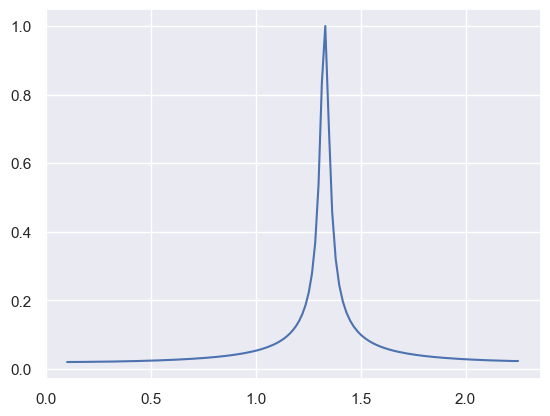

In [532]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
TTF_values = scaler.fit_transform(TTF_data.T).T
print(TTF_values.shape)

plt.plot(freq_data, TTF_values[-1,:], label="TTF")

In [533]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [534]:
dataset = TTF_dataset(TTF_values, Vs_data)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  116 15 15
Number of batches:  2 1 1


# Model

In [535]:
# Let's do a RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, device="cpu"):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)   
        out = self.fc(out[:, -1, :])
        return out  

In [536]:
# Sequence-to-sequence model
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Define the Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h1):
        out, h1 = self.rnn(x, h1)
        out = self.fc(out[:, -1, :])
        return out, h1

In [537]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(1)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs)
        return nn.functional.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [538]:
class DecoderRNNWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderRNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        out, hidden = self.gru(gru_input, hidden)
        out = self.fc(torch.cat([out, context], 2))
        return out, hidden

In [539]:
# Define the Encoder LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        return out, (h1, c1)

# Define the Decoder LSTM with Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        h1, c1 = hidden
        attn_weights = self.attention(h1[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        lstm_input = torch.cat([x, context], 2)
        out, (h1, c1) = self.lstm(lstm_input, (h1, c1))
        out = self.fc(torch.cat([out, context], 2))
        return out, (h1, c1)

In [540]:
class Seq2Seq_3(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq_3, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, device="cpu"):
        encoder_outputs, hidden = self.encoder(x)
        decoder_input = torch.zeros(x.size(0), 1, self.encoder.hidden_size).to(device)
        output, _ = self.decoder(decoder_input, hidden, encoder_outputs)
        return output.squeeze(1)

In [541]:
# Define the Encoder GRU
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, h1 = self.gru(x, h0)
        return out, h1

# Define the Decoder GRU with Attention
class DecoderGRUWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderGRUWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(hidden_size * 2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)
        gru_input = torch.cat([x, context], 2)
        out, hidden = self.gru(gru_input, hidden)
        out = self.fc(torch.cat([out, context], 2))
        return out, hidden

In [542]:
class Seq2Seq_4(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq_4, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, device="cpu"):
        encoder_outputs, hidden = self.encoder(x)
        decoder_input = torch.zeros(x.size(0), 1, self.encoder.hidden_size).to(device)
        output, _ = self.decoder(decoder_input, hidden, encoder_outputs)
        return output.squeeze(1)

In [543]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, device="cpu"):
        out, h1 = self.encoder(x)
        out, _ = self.decoder(out, h1)
        return out

class Seq2Seq_2(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq_2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, device="cpu"):
        encoder_outputs, hidden = self.encoder(x)
        decoder_input = torch.zeros(x.size(0), 1, self.encoder.hidden_size).to(device)
        output, _ = self.decoder(decoder_input, hidden, encoder_outputs)
        return output.squeeze(1)

In [544]:
# Initialize the models
input_size = 1
hidden_size = 300
num_layers = 2
output_size = 256


# Initialize the models
encoder = EncoderGRU(input_size, hidden_size, num_layers)
decoder = DecoderGRUWithAttention(hidden_size, output_size, num_layers)
model = Seq2Seq_4(encoder, decoder)


In [545]:
# Check if the model works
X,y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
print("Model output shape: ", model(X).shape)
assert model(X).shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(model(X), y))


Input shape:  torch.Size([100, 30, 1]) Output shape:  torch.Size([100, 256])
Model output shape:  torch.Size([100, 256])
tensor(0.0510, grad_fn=<MseLossBackward0>)


In [546]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [547]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50, clipping=True):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 250 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu"):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [548]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-08)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

# Training
num_epochs = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

Device:  cuda


In [549]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1000, clipping=True)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training:   0%|          | 1/10000 [00:00<21:33,  7.73epoch/s]

Epoch 0, Train Loss: 0.14377816021442413, Val Loss: 0.08273808658123016, LR: 0.001


Training:   3%|▎         | 254/10000 [00:11<07:24, 21.95epoch/s, EarlyStopping counter: 4 out of 1000] 

Epoch 250, Train Loss: 0.023686244152486324, Val Loss: 0.02155769057571888, LR: 0.001


Training:   5%|▌         | 503/10000 [00:23<06:52, 23.00epoch/s, EarlyStopping counter: 6 out of 1000] 

Epoch 500, Train Loss: 0.02049862965941429, Val Loss: 0.020072834566235542, LR: 0.001


Training:   8%|▊         | 752/10000 [00:34<07:41, 20.06epoch/s, EarlyStopping counter: 142 out of 1000]

Epoch 750, Train Loss: 0.01939629763364792, Val Loss: 0.019687240943312645, LR: 0.001


Training:  10%|█         | 1004/10000 [00:46<06:58, 21.49epoch/s, EarlyStopping counter: 46 out of 1000]

Epoch 1000, Train Loss: 0.021104748360812664, Val Loss: 0.020479166880249977, LR: 0.001


Training:  13%|█▎        | 1253/10000 [00:57<06:40, 21.83epoch/s, EarlyStopping counter: 74 out of 1000]

Epoch 1250, Train Loss: 0.018811030313372612, Val Loss: 0.019013667479157448, LR: 0.001


Training:  15%|█▌        | 1505/10000 [01:08<06:18, 22.44epoch/s, EarlyStopping counter: 26 out of 1000]

Epoch 1500, Train Loss: 0.018902509473264217, Val Loss: 0.018509386107325554, LR: 0.001


Training:  18%|█▊        | 1754/10000 [01:20<06:17, 21.84epoch/s, EarlyStopping counter: 34 out of 1000] 

Epoch 1750, Train Loss: 0.018306165002286434, Val Loss: 0.01758453994989395, LR: 0.001


Training:  20%|██        | 2003/10000 [01:32<07:34, 17.58epoch/s, EarlyStopping counter: 139 out of 1000]

Epoch 2000, Train Loss: 0.01845978107303381, Val Loss: 0.017294935882091522, LR: 0.001


Training:  23%|██▎       | 2253/10000 [01:46<06:57, 18.55epoch/s, EarlyStopping counter: 103 out of 1000]

Epoch 2250, Train Loss: 0.017539300955832005, Val Loss: 0.017554892227053642, LR: 0.001


Training:  25%|██▌       | 2503/10000 [02:01<06:48, 18.34epoch/s, EarlyStopping counter: 89 out of 1000] 

Epoch 2500, Train Loss: 0.017045876942574978, Val Loss: 0.016881221905350685, LR: 0.001


Training:  28%|██▊       | 2753/10000 [02:15<06:52, 17.56epoch/s, EarlyStopping counter: 150 out of 1000]

Epoch 2750, Train Loss: 0.017756507731974125, Val Loss: 0.01721741259098053, LR: 0.001


Training:  30%|███       | 3003/10000 [02:30<09:22, 12.44epoch/s, EarlyStopping counter: 225 out of 1000]

Epoch 3000, Train Loss: 0.0179182393476367, Val Loss: 0.018207216635346413, LR: 0.001


Training:  33%|███▎      | 3252/10000 [02:46<07:30, 14.99epoch/s, EarlyStopping counter: 23 out of 1000] 

Epoch 3250, Train Loss: 0.015711582265794277, Val Loss: 0.015802795067429543, LR: 0.001


Training:  35%|███▌      | 3502/10000 [03:03<07:29, 14.45epoch/s, EarlyStopping counter: 125 out of 1000]

Epoch 3500, Train Loss: 0.016190006397664547, Val Loss: 0.016193311661481857, LR: 0.001


Training:  38%|███▊      | 3752/10000 [03:24<08:55, 11.67epoch/s, EarlyStopping counter: 375 out of 1000]

Epoch 3750, Train Loss: 0.01621911721304059, Val Loss: 0.01594163104891777, LR: 0.001


Training:  40%|████      | 4002/10000 [03:45<07:45, 12.88epoch/s, EarlyStopping counter: 124 out of 1000]

Epoch 4000, Train Loss: 0.015174474101513624, Val Loss: 0.01554946880787611, LR: 0.001


Training:  43%|████▎     | 4253/10000 [04:06<07:44, 12.38epoch/s, EarlyStopping counter: 204 out of 1000]

Epoch 4250, Train Loss: 0.01583630358800292, Val Loss: 0.015833979472517967, LR: 0.001


Training:  45%|████▌     | 4503/10000 [04:27<08:20, 10.98epoch/s, EarlyStopping counter: 53 out of 1000] 

Epoch 4500, Train Loss: 0.013375426642596722, Val Loss: 0.01509443111717701, LR: 0.001


Training:  48%|████▊     | 4753/10000 [04:50<07:35, 11.52epoch/s, EarlyStopping counter: 126 out of 1000]

Epoch 4750, Train Loss: 0.014529102481901646, Val Loss: 0.01603488065302372, LR: 0.001


Training:  50%|█████     | 5001/10000 [05:14<07:38, 10.89epoch/s, EarlyStopping counter: 115 out of 1000]

Epoch 5000, Train Loss: 0.013729935977607965, Val Loss: 0.0144735649228096, LR: 0.001


Training:  53%|█████▎    | 5253/10000 [05:36<07:08, 11.07epoch/s, EarlyStopping counter: 94 out of 1000] 

Epoch 5250, Train Loss: 0.01410038536414504, Val Loss: 0.01483524776995182, LR: 0.001


Training:  55%|█████▌    | 5502/10000 [05:59<07:16, 10.30epoch/s, EarlyStopping counter: 344 out of 1000]

Epoch 5500, Train Loss: 0.013667831663042307, Val Loss: 0.016308702528476715, LR: 0.001


Training:  58%|█████▊    | 5752/10000 [06:22<06:04, 11.66epoch/s, EarlyStopping counter: 22 out of 1000] 

Epoch 5750, Train Loss: 0.010913955047726631, Val Loss: 0.012751872651278973, LR: 0.0005


Training:  60%|██████    | 6004/10000 [06:41<04:16, 15.59epoch/s, EarlyStopping counter: 23 out of 1000] 

Epoch 6000, Train Loss: 0.010876793880015612, Val Loss: 0.013449296355247498, LR: 0.0005


Training:  63%|██████▎   | 6252/10000 [06:59<05:39, 11.03epoch/s, EarlyStopping counter: 31 out of 1000] 

Epoch 6250, Train Loss: 0.010774839203804731, Val Loss: 0.012700434774160385, LR: 0.0005


Training:  65%|██████▌   | 6501/10000 [07:23<05:21, 10.90epoch/s, EarlyStopping counter: 280 out of 1000]

Epoch 6500, Train Loss: 0.010857811663299799, Val Loss: 0.012643367052078247, LR: 0.0005


Training:  68%|██████▊   | 6751/10000 [07:46<05:04, 10.68epoch/s, EarlyStopping counter: 19 out of 1000] 

Epoch 6750, Train Loss: 0.009200429543852806, Val Loss: 0.011696698144078255, LR: 0.00025


Training:  70%|███████   | 7003/10000 [08:03<02:56, 16.95epoch/s, EarlyStopping counter: 69 out of 1000]

Epoch 7000, Train Loss: 0.0086286049336195, Val Loss: 0.01152193546295166, LR: 0.00025


Training:  73%|███████▎  | 7252/10000 [08:22<05:01,  9.11epoch/s, EarlyStopping counter: 85 out of 1000] 

Epoch 7250, Train Loss: 0.008902483154088259, Val Loss: 0.011588100343942642, LR: 0.00025


Training:  75%|███████▌  | 7502/10000 [08:41<02:48, 14.81epoch/s, EarlyStopping counter: 113 out of 1000]

Epoch 7500, Train Loss: 0.009533194359391928, Val Loss: 0.011371553875505924, LR: 0.00025


Training:  78%|███████▊  | 7752/10000 [08:58<02:35, 14.42epoch/s, EarlyStopping counter: 28 out of 1000] 

Epoch 7750, Train Loss: 0.008629918564110994, Val Loss: 0.0116506302729249, LR: 0.00025


Training:  80%|████████  | 8002/10000 [09:15<02:08, 15.59epoch/s, EarlyStopping counter: 278 out of 1000]

Epoch 8000, Train Loss: 0.008610110264271498, Val Loss: 0.011249871924519539, LR: 0.00025


Training:  83%|████████▎ | 8252/10000 [09:32<01:54, 15.27epoch/s, EarlyStopping counter: 2 out of 1000]  

Epoch 8250, Train Loss: 0.008013000711798668, Val Loss: 0.010981529951095581, LR: 0.000125


Training:  85%|████████▌ | 8502/10000 [09:48<01:35, 15.61epoch/s, EarlyStopping counter: 139 out of 1000]

Epoch 8500, Train Loss: 0.008014942053705454, Val Loss: 0.010970176197588444, LR: 0.000125


Training:  88%|████████▊ | 8752/10000 [10:06<01:27, 14.26epoch/s, EarlyStopping counter: 199 out of 1000]

Epoch 8750, Train Loss: 0.007938386872410774, Val Loss: 0.010838977061212063, LR: 0.000125


Training:  90%|█████████ | 9004/10000 [10:22<01:00, 16.49epoch/s, EarlyStopping counter: 9 out of 1000]  

Epoch 9000, Train Loss: 0.007834706455469131, Val Loss: 0.010827258229255676, LR: 0.000125


Training:  93%|█████████▎| 9252/10000 [10:38<00:50, 14.93epoch/s]                                        

Epoch 9250, Train Loss: 0.007778770988807082, Val Loss: 0.010682027786970139, LR: 0.000125


Training:  95%|█████████▌| 9502/10000 [10:59<00:37, 13.38epoch/s, EarlyStopping counter: 110 out of 1000]

Epoch 9500, Train Loss: 0.008239287650212646, Val Loss: 0.010915763676166534, LR: 0.000125


Training:  98%|█████████▊| 9752/10000 [11:21<00:14, 17.38epoch/s, EarlyStopping counter: 45 out of 1000] 

Epoch 9750, Train Loss: 0.007775700418278575, Val Loss: 0.01079515926539898, LR: 0.000125


Training: 100%|██████████| 10000/10000 [11:36<00:00, 14.37epoch/s, EarlyStopping counter: 8 out of 1000] 


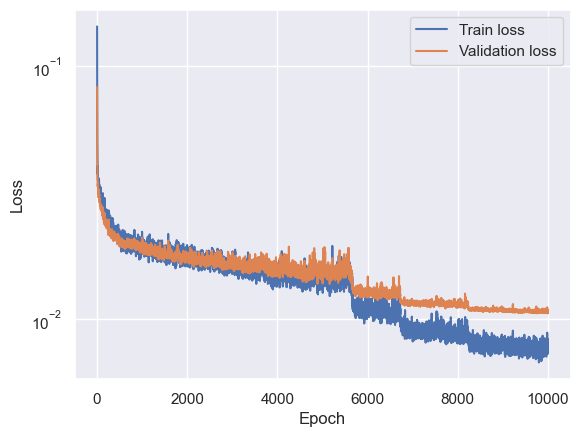

In [550]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [551]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.01464343722909689


In [552]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

print(target.shape, predicted.shape, Vs_data.shape)

(15, 256) (15, 256) (15, 30, 1)


In [553]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i, " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0  :  0.9561625403023655
Correlation factor for TTF  1  :  0.9228770249030762
Correlation factor for TTF  2  :  0.8466408076185985
Correlation factor for TTF  3  :  0.894179239517257
Correlation factor for TTF  4  :  0.8902735705182181
Correlation factor for TTF  5  :  0.92431895485187
Correlation factor for TTF  6  :  0.8367881572032729
Correlation factor for TTF  7  :  0.9013031104028641
Correlation factor for TTF  8  :  0.9319956005845142
Correlation factor for TTF  9  :  0.9680230035535864
Correlation factor for TTF  10  :  0.9463705257645074
Correlation factor for TTF  11  :  0.9382461932822324
Correlation factor for TTF  12  :  0.8780597824338088
Correlation factor for TTF  13  :  0.8923411382297104
Correlation factor for TTF  14  :  0.862658902141785


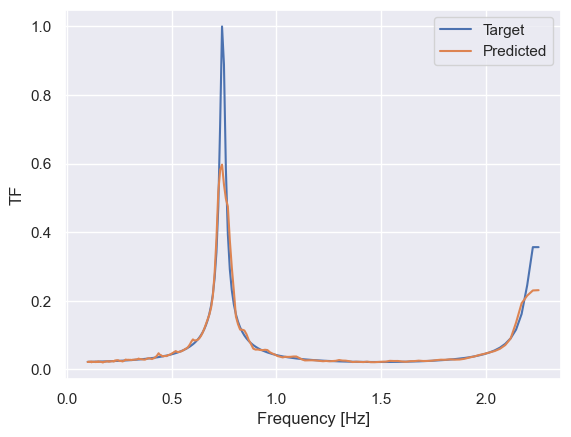

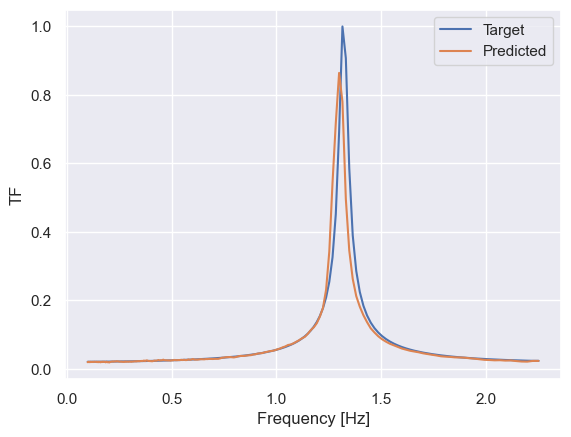

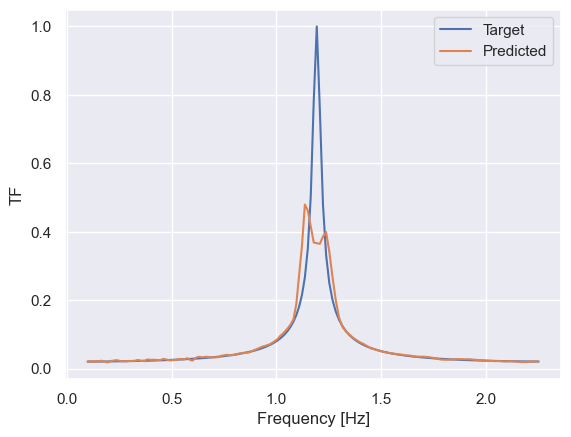

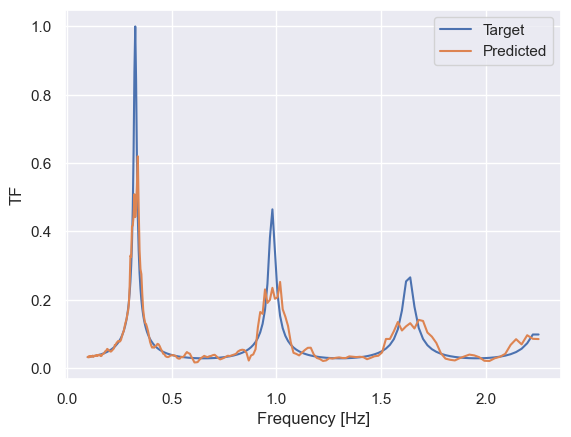

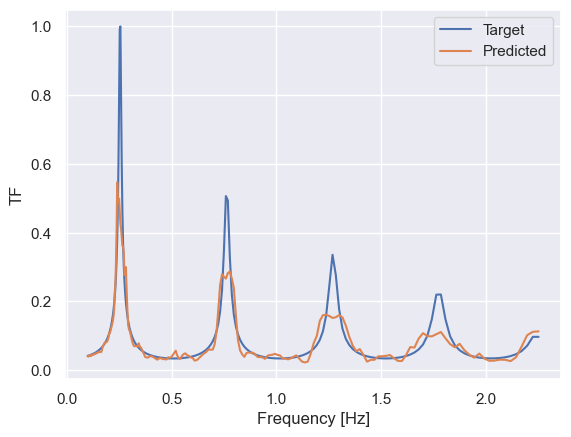

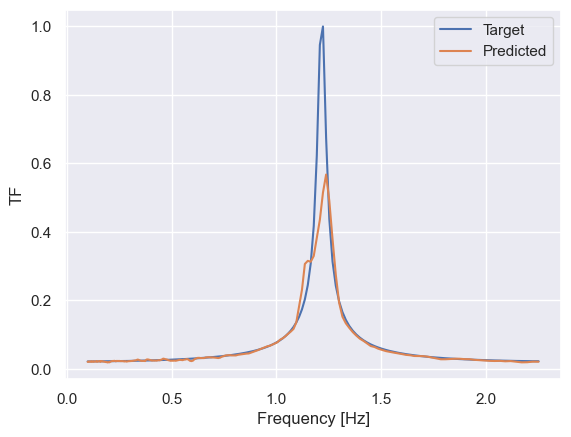

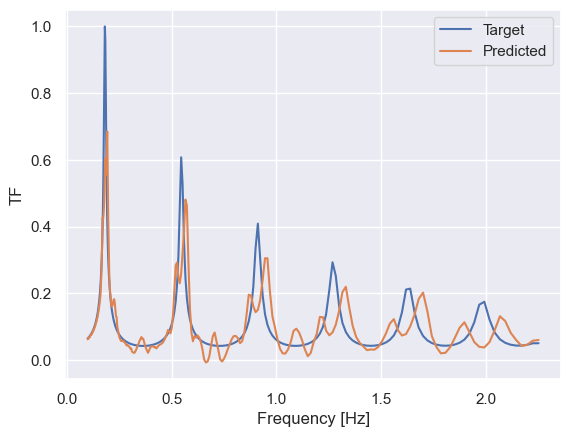

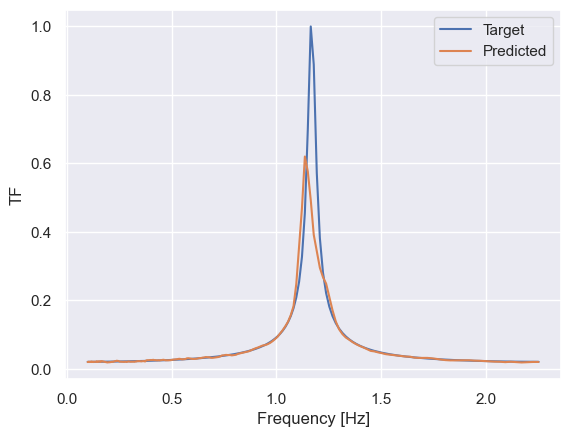

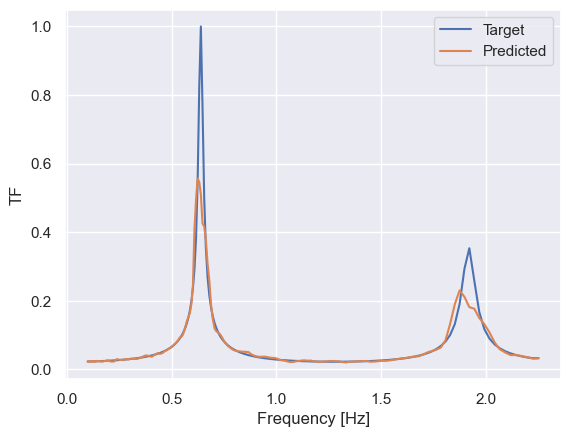

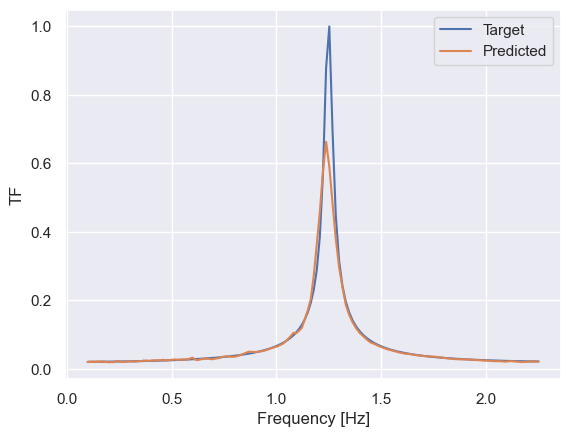

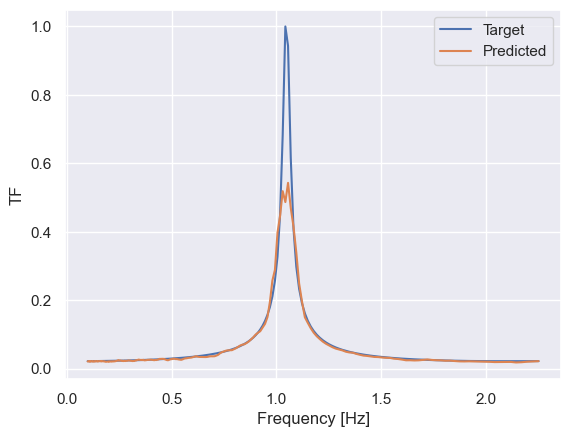

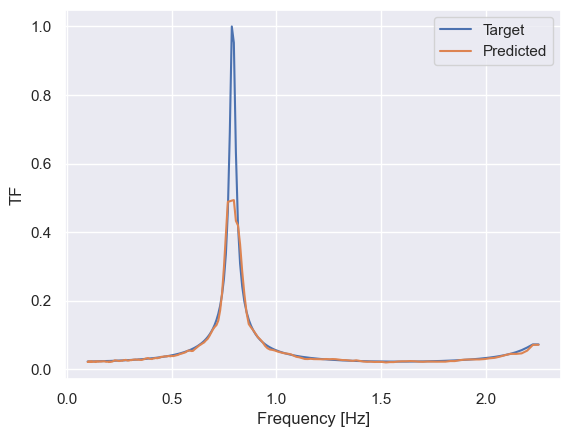

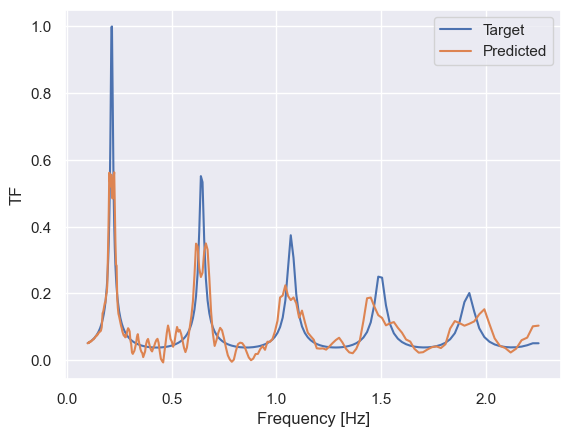

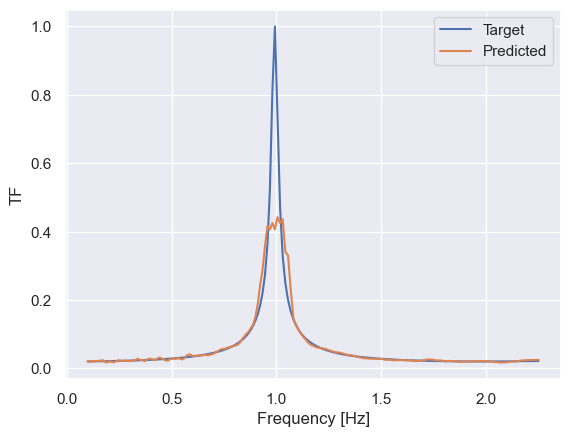

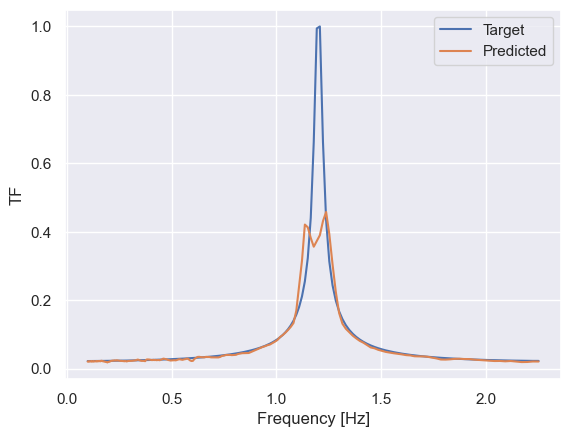

In [554]:
for i in range(target.shape[0]):
    plt.plot(freq_data, target[i,:], label="Target")
    plt.plot(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.legend()
    plt.show()